# Five Applied Econometric Methods for Causal Inference

In [48]:
# Preliminaries

library(dplyr)
library(magrittr)
library(MASS)
library(ggplot2)

set.seed(1)
n <- 10 ^ 3
mu <- matrix(c(0, 0))
rho <- 0.5
sigma1 <- 0.5
sigma2 <- 2
Sigma <- matrix(c(sigma1 ^ 2, 
                  rho * sigma1 * sigma2, 
                  rho * sigma1 * sigma2, 
                  sigma2 ^ 2),
                c(2, 2))

simulatedXandC <- mvrnorm(n = n, mu = mu, Sigma = Sigma)
simulatedError <- rnorm(n = n)
simulatedZ <- round(runif(n))
group <- round(runif(n))

## Method 1: Controlled Regression

In [49]:
df <- data.frame(X = simulatedXandC[, 1],
                 C = simulatedXandC[, 2],
                 error = simulatedError)
df %<>%
    mutate(Y = 10 + 1 * X + 5 * C + error)

fit <- lm(Y ~ X, data = df)
summary(fit)

fit <- lm(Y ~ X + C, data = df)
summary(fit)


Call:
lm(formula = Y ~ X, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.343  -6.053   0.328   5.787  35.597 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   9.8560     0.2884   34.18   <2e-16 ***
X            10.8872     0.5571   19.54   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.118 on 998 degrees of freedom
Multiple R-squared:  0.2767,	Adjusted R-squared:  0.276 
F-statistic: 381.9 on 1 and 998 DF,  p-value: < 2.2e-16



Call:
lm(formula = Y ~ X + C, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6151 -0.6564 -0.0223  0.6815  2.8132 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.01624    0.03260  307.27   <2e-16 ***
X            0.95233    0.07242   13.15   <2e-16 ***
C            5.03078    0.01812  277.71   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.031 on 997 degrees of freedom
Multiple R-squared:  0.9908,	Adjusted R-squared:  0.9908 
F-statistic: 5.351e+04 on 2 and 997 DF,  p-value: < 2.2e-16


## Method 2: Regression Discontinuity Design (RDD)


Call:
RDestimate(formula = Y ~ X, data = df)

Type:
sharp 

Estimates:
           Bandwidth  Observations  Estimate  Std. Error  z value  Pr(>|z|) 
LATE       0.4093     572           4.940     0.3750      13.173   1.255e-39
Half-BW    0.2046     299           4.943     0.5122       9.649   4.959e-22
Double-BW  0.8186     883           5.014     0.2781      18.029   1.158e-72
              
LATE       ***
Half-BW    ***
Double-BW  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

F-statistics:
           F      Num. DoF  Denom. DoF  p
LATE       340.8  3         568         0
Half-BW    164.0  3         295         0
Double-BW  622.0  3         879         0


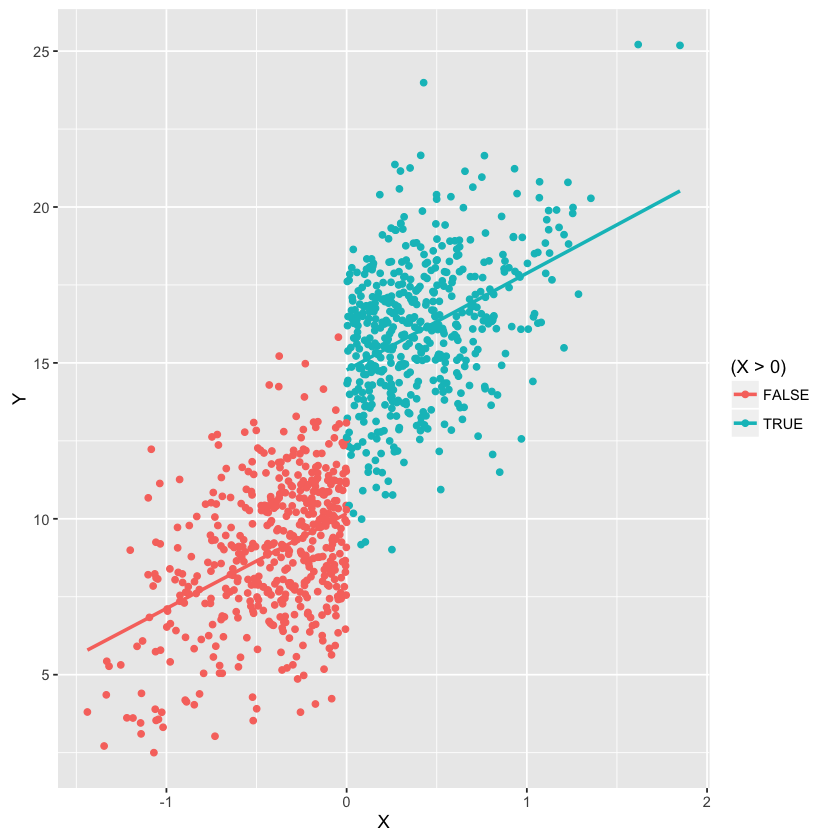

In [91]:
# Regression discontinuity design

library(rdd)

df <- data.frame(X = simulatedXandC[, 1],
                 C = simulatedXandC[, 2],
                 T = (simulatedXandC[, 1] > 0),
                 error = simulatedError)

df %<>%
    mutate(Y = 10 + X ^ 3 + 5 * T + 1 * C + error)

fit <- RDestimate(Y ~ X, data = df)
summary(fit)

ggplot(data = df, aes(x = X, y = Y, color = (X > 0))) + 
    geom_point() +
    geom_smooth(method = lm,   
                se = FALSE)

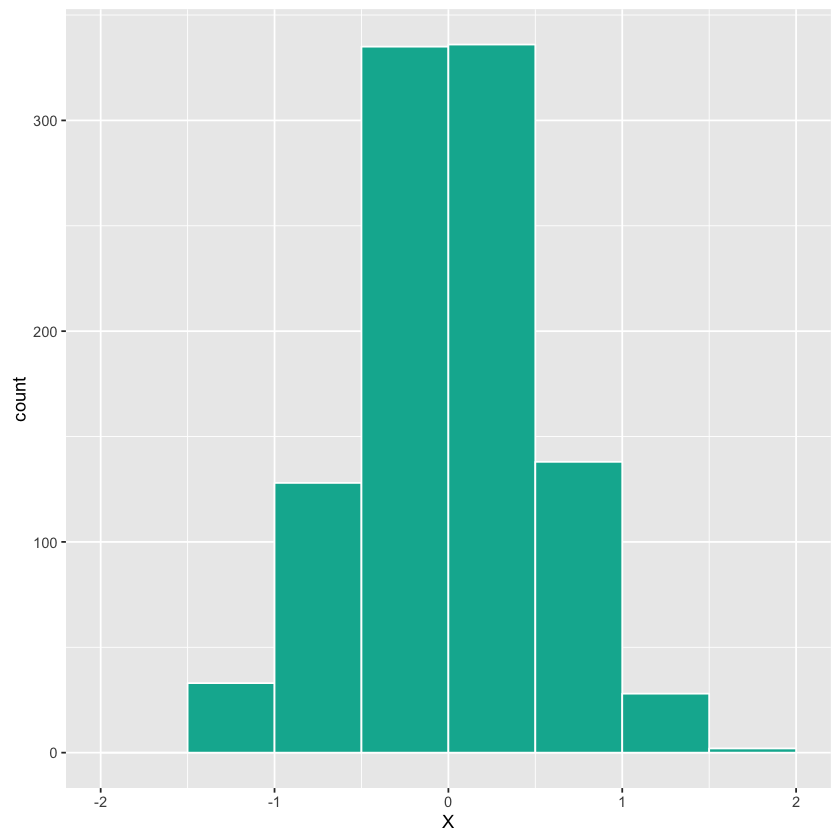

In [93]:
# no bunching
df %>% 
    ggplot(aes(x = X)) + 
        geom_histogram(breaks = seq(-2, 2, 0.5), colour="white", fill = "#00B39F")

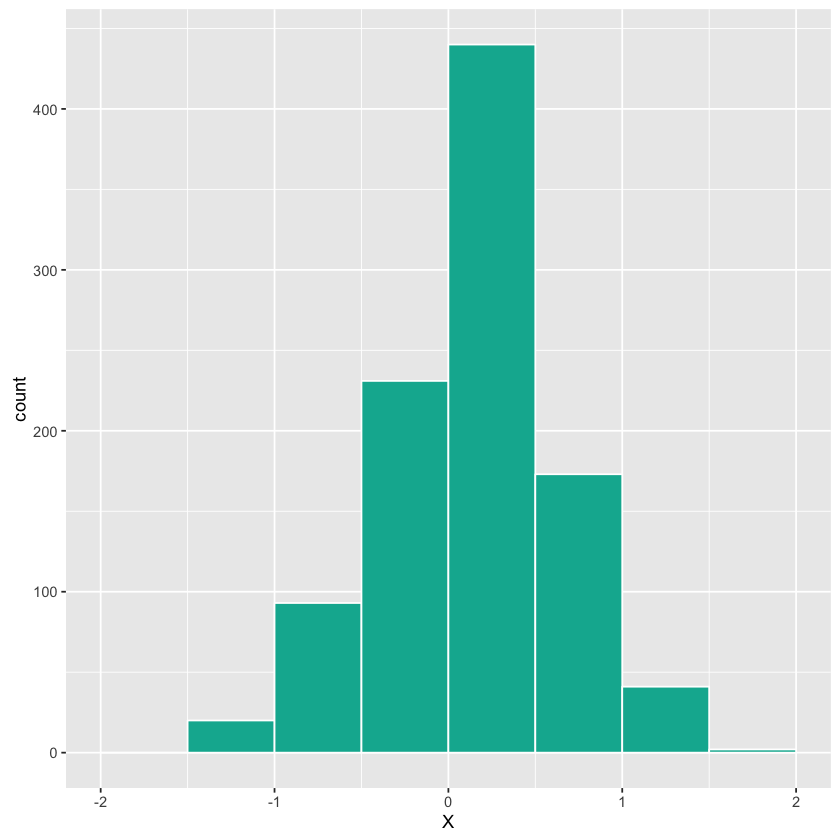

In [95]:
# bunching
df %>%
    mutate(rand = runif(n()),
           X = ifelse(rand < 0.33 & X < 0, -X, X)) %>%
    ggplot(aes(x = X)) + 
        geom_histogram(breaks = seq(-2, 2, 0.5), colour="white", fill = "#00B39F")

In [ ]:
# 

## Method 3: Difference-in-Differences (DD)


Call:
lm(formula = Y ~ time + treatment + I((time >= 0) * treatment), 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5101 -0.6419 -0.0333  0.6987  2.8743 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 1.00254    0.04517   22.20   <2e-16 ***
time                       -1.00867    0.01372  -73.50   <2e-16 ***
treatment                   5.04337    0.09095   55.45   <2e-16 ***
I((time >= 0) * treatment)  6.96797    0.11938   58.37   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.032 on 996 degrees of freedom
Multiple R-squared:  0.9595,	Adjusted R-squared:  0.9594 
F-statistic:  7864 on 3 and 996 DF,  p-value: < 2.2e-16


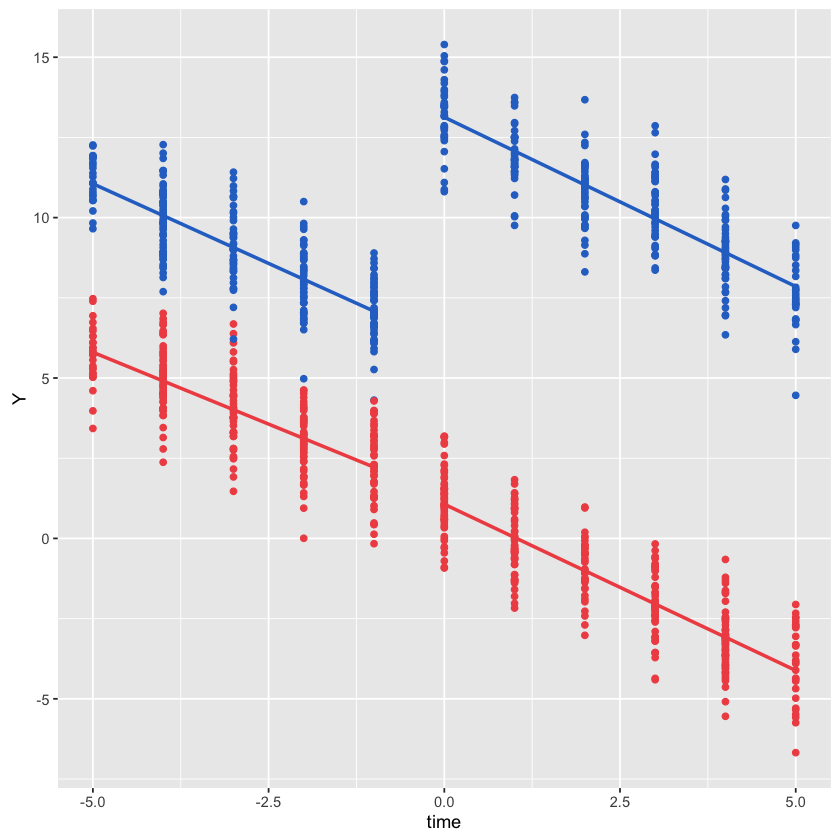

In [89]:
# Difference-in-differences

df <- data.frame(time = 10 * round(runif(n), 1) - 5,
                 treatment = group,
                 error = simulatedError)

df %<>%
    mutate(Y = 1 - time + 5 * treatment + 7 * (time >= 0) * treatment + error)

fit <- lm(Y ~ time + treatment + I((time >= 0) * treatment), data = df)
summary(fit)

dfMean <- df %>%
    group_by(time, treatment) %>%
    summarise(Y = mean(Y))

ggplot(data = df, aes(x = time, y = Y, color = factor(treatment + 2 * (time >= 0)))) + 
    geom_point() + 
    geom_smooth(method = lm,   
                se = FALSE) + 
    theme(legend.position = "none") + 
    scale_color_manual(values = c("#F05253", "#2A73CC", "#F05253", "#2A73CC")) 

## Method 4: Fixed-Effects Regression (FE)

In [6]:
# Fixed-effects regression

df <- data.frame(X = simulatedXandC[, 1],
                 C = round(pmin(2, pmax(-2, simulatedXandC[, 2]))),
                 error = simulatedError)
df %<>%
    mutate(Y = 10 + 1 * X + 5 * C + error)

fit <- lm(Y ~ X, data = df)
summary(fit)

fit <- lm(Y ~ X + factor(C), data = df)
summary(fit)


Call:
lm(formula = Y ~ X, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.7123  -5.3978  -0.0537   5.5151  15.2279 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   9.8147     0.2102   46.69   <2e-16 ***
X             7.7857     0.4084   19.06   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.647 on 998 degrees of freedom
Multiple R-squared:  0.2669,	Adjusted R-squared:  0.2662 
F-statistic: 363.3 on 1 and 998 DF,  p-value: < 2.2e-16



Call:
lm(formula = Y ~ X + factor(C), data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1829 -0.6396  0.0089  0.6546  2.8850 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.03909    0.06508   0.601    0.548    
X            0.95441    0.06668  14.313   <2e-16 ***
factor(C)-1  5.09927    0.09583  53.214   <2e-16 ***
factor(C)0   9.96171    0.09405 105.917   <2e-16 ***
factor(C)1  14.96551    0.10212 146.545   <2e-16 ***
factor(C)2  20.10901    0.09932 202.471   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9546 on 994 degrees of freedom
Multiple R-squared:  0.9849,	Adjusted R-squared:  0.9849 
F-statistic: 1.3e+04 on 5 and 994 DF,  p-value: < 2.2e-16


## Method 5: Instrumental Variables (IV)

In [7]:
# Instrumental variables

df <- data.frame(Z = simulatedZ,   
                 X = simulatedXandC[, 1] + simulatedZ,
                 C = simulatedXandC[, 2],
                 error = simulatedError)
df %<>%
    mutate(Y = 10 + 1.0 * X - 2 * C + error)

# Naive regression produces biased estimates
fit <- lm(Y ~ X, data = df)
summary(fit,  vcov = sandwich)

# IV recovers the underlying model
fit <- ivreg(Y ~ X | Z, data = df)
summary(fit,  vcov = sandwich, df = Inf, diagnostics = TRUE)


Call:
lm(formula = Y ~ X, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.6708  -2.7359   0.0389   2.6774  13.5484 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  11.2014     0.1531  73.165  < 2e-16 ***
X            -1.0045     0.1746  -5.755 1.15e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.847 on 998 degrees of freedom
Multiple R-squared:  0.03212,	Adjusted R-squared:  0.03115 
F-statistic: 33.11 on 1 and 998 DF,  p-value: 1.155e-08



Call:
ivreg(formula = Y ~ X | Z, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.5369  -2.8368   0.0734   2.8959  13.5903 

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  10.0315     0.2011  49.871  < 2e-16 ***
X             1.1929     0.2784   4.285 1.83e-05 ***

Diagnostic tests:
                 df1 df2 statistic p-value    
Weak instruments   1 998     839.9  <2e-16 ***
Wu-Hausman         1 997     154.7  <2e-16 ***
Sargan             0  NA        NA      NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.141 on Inf degrees of freedom
Multiple R-Squared: -0.1216,	Adjusted R-squared: -0.1227 
Wald test: 18.36 on 1 DF,  p-value: 1.826e-05 
